In [1]:
import pandas as pd
from scipy.optimize import curve_fit 
import numpy as np
from IPython.display import clear_output
import mesa
import scipy.optimize as opt
import math
from scipy.optimize import Bounds
from functools import reduce
from mesa.batchrunner import BatchRunner
import os
import time
from sex_distortion import SexDistortion
clear_output(wait=True)
SexDistortion

sex_distortion.SexDistortion

In [2]:
#Read CFPS data
df=pd.read_csv('data/cfps2014adult.csv',delimiter='\t')
child_df=pd.read_csv('data/cfps2014child.csv',delimiter='\t')
appendix=pd.read_csv('data/append_income.csv',delimiter='\t')

<ipython-input-5-928890c57877>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  child['total_test']=child['word_test'].astype('float')+child['math_test'].astype('float')
<ipython-input-5-928890c57877>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  child_sup['family_edu_cost']=child_sup['family_edu_cost'].replace(['不适用','不知道'],'0').astype('float')
<ipython-input-5-928890c57877>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

1700.0
[ 0.28925115  1.43600609 -0.19679485]


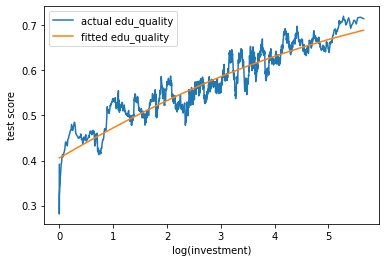

In [5]:
#I-E model parameter estimation

child=child_df[(child_df['birth_year']<2007)
          & ~(child_df['word_test'].isna()) & (child_df['word_test']!='不适用')]
child['total_test']=child['word_test'].astype('float')+child['math_test'].astype('float')
child=child.drop(['word_test','math_test'],axis=1)
child_sup=df[(df['birth_year']>1996) & (df['self_edu_cost']!='不适用') & (df['income']=='0')]
child_sup['family_edu_cost']=child_sup['family_edu_cost'].replace(['不适用','不知道'],'0').astype('float')
child_sup['self_edu_cost']=child_sup['self_edu_cost'].fillna(0)
child_sup=child_sup[['id','gender','birth_year','highest_edu','family_edu_cost','self_edu_cost']]
child_sup['edu_cost']=child_sup.apply(lambda r:max(float(r.family_edu_cost),float(r.self_edu_cost)),axis=1)
child_sup=child_sup.drop(['family_edu_cost','self_edu_cost'],axis=1)
child_sup['total_test']=np.nan
child_sup.columns=['child_id','gender','birth_year','school_year','edu_cost','total_test']
child_sup=child_sup[['child_id','birth_year','gender','edu_cost','school_year','total_test']]
child=pd.concat([child,child_sup],axis=0)

#MODEL
import matplotlib.pyplot as plt
inv_edu=child[~(child['total_test'].isna())&~(child['edu_cost'].isna())][['edu_cost','total_test','gender']]
minimum=np.min(inv_edu['total_test'])
maximum=np.max(inv_edu['total_test'])
edu_daughter=inv_edu[inv_edu['gender']=='女'][['edu_cost','total_test']]
edu_son=inv_edu[inv_edu['gender']=='男'][['edu_cost','total_test']]
edu_daughter=sorted(edu_daughter.to_numpy(),key=lambda x:x[0])
edu_son=sorted(edu_son.to_numpy(),key=lambda x:x[0])
edus=edu_daughter=inv_edu[['edu_cost','total_test']]
edus=sorted(edus.to_numpy(),key=lambda x:x[0])


def func_sigmoid(x,c1,c2,c3):
    return 1/(np.exp(-c1*(x+c2))+1)+c3

f=plt.figure()
x=[]
y=[]
for i in edus:
    x.append(i[0])
    y.append(i[1])
print(np.median(x))
min_inv=np.min(x)
max_inv=np.max(x)
x=np.ma.convolve(x,np.ones(50,dtype=int),'valid')/50
x=np.log(x/100+1)
# x=norm(x)
y=np.ma.convolve(y,np.ones(50,dtype=int),'valid')/50
y=(y-minimum)/(maximum-minimum)
plt.plot(x,y,label='actual edu_quality')
iem_param,cov=curve_fit(func_sigmoid,x,y)
result=[func_sigmoid(i,iem_param[0],iem_param[1],iem_param[2]) for i in x]
plt.plot(x,result,label='fitted edu_quality')
plt.xlabel("log(investment)")
plt.ylabel("test score")
plt.legend()
print(iem_param)
#edu_inv quantity  sublinear


/Users/sunweber/.local/share/virtualenvs/abm-assignments-nFGxnKtf/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
<ipython-input-8-da4420a72a64>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_p['family_income']=sub_p['income'].astype('float')+sub_p['c.income'].astype('float')
<ipython-input-8-da4420a72a64>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

[0.01394223 1.07057479]


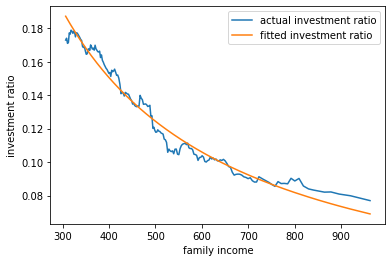

In [8]:
#I-I model paramster estimation

adults=df[(df['birth_year']<1984) & (df['birth_year']>1964) 
          & (df['highest_edu']!='没数据') & ~(df['residence'].isna())
          & (df['marriage']=='在婚（有配偶）') & (df['couple_id']!='不适用') &(df['income']!='缺失')]
adults=adults.drop(['father_id','mother_id','self_edu_cost','marriage'],axis=1)
adults['couple_id']=adults['couple_id'].astype('int64')
adults['child1_id']=adults['child1_id'].replace(['不适用'],'0').astype('int64')
adults['child2_id']=adults['child2_id'].replace(['不适用'],'0').astype('int64')
adults['child3_id']=adults['child3_id'].replace(['不适用'],'0').astype('int64')
adults['child4_id']=adults['child4_id'].replace(['不适用'],'0').astype('int64')

adults=pd.merge(left=adults,right=appendix,left_on='id',right_on='id', how='left')
adults['income']=adults.apply(lambda r:max(float(r.income),float(r.other_income)),axis=1)
adults=adults.drop(['other_income'],axis=1)

a1c=adults[adults['child1_id']!='不适用']
a1c['child1_id']=a1c['child1_id'].astype('int64')
temp=adults[['id','gender','highest_edu','income','residence','atleast_ason']]
temp.columns=['id','c.gender','c.edu','c.income','c.residence','c.son_p']
# temp=temp.set_index(['id'],inplace=False)
# a1c=a1c.set_index(['id'],inplace=False)
parents=pd.merge(left=a1c,right=temp,left_on='couple_id',right_on='id')

#family size
# family_total=pd.merge(left=parents,right=child,left_on='child1_id',right_on='child_id')
sub_p=parents[['id_x','child1_id','child2_id','child3_id',
        'child4_id','gender','highest_edu','residence','income','c.gender','c.edu','c.income','c.residence']]
sub_p['family_income']=sub_p['income'].astype('float')+sub_p['c.income'].astype('float')
# mini=np.min(sub_p['family_income'])
# maxi=np.max(sub_p['family_income'])
# sub_p['family_income']=(sub_p['family_income'].apply(lambda x:(x-mini)/(maxi-mini)))
# sub_p=sub_p.drop(['income','c.income'],axis=1)
# child['dummy_id']=child['child_id'].astype(object)
sub_p=sub_p.drop_duplicates(subset=['child1_id'])
sub_p=sub_p[sub_p['family_income']!=0]
fml1=pd.merge(left=sub_p,right=child,left_on='child1_id',right_on='child_id',suffixes=(None,"_1"))
fml2=pd.merge(left=fml1,right=child,left_on='child2_id',right_on='child_id',suffixes=(None,"_2"))
fml3=pd.merge(left=fml2,right=child,left_on='child3_id',right_on='child_id',suffixes=(None,"_3"))
# fml=pd.merge(left=fml4,right=child,left_on='child4_id',right_on='child_id',how='left',suffixes=(None,"_4"))
fml1=fml1[fml1['child2_id']==0].drop(['child1_id','child2_id','child3_id','child4_id'],axis=1)
fml2=fml2[fml2['child3_id']==0].drop(['child1_id','child2_id','child3_id','child4_id'],axis=1)
fml3=fml3[fml3['child4_id']==0].drop(['child1_id','child2_id','child3_id','child4_id'],axis=1)

data1=fml1[['family_income','edu_cost']]
data1['edu_cost']=data1['edu_cost'].fillna(0)
data2=fml2[['family_income','edu_cost','edu_cost_2']]
data2['edu_cost']=data2['edu_cost'].fillna(0)+data2['edu_cost_2'].fillna(0)
data2=data2.drop(['edu_cost_2'],axis=1)
data3=fml3[['family_income','edu_cost','edu_cost_2','edu_cost_3']]
data3['edu_cost']=data3['edu_cost'].fillna(0)+data3['edu_cost_2'].fillna(0)+data3['edu_cost_3'].fillna(0)
data3=data3.drop(['edu_cost_2','edu_cost_3'],axis=1)

#income-edu_cost 
#MODEL
income_edu1=data1[data1['family_income']>20000]
income_edu2=data2[data2['family_income']>20000]
income_edu3=data3[data3['family_income']>20000]
ie1=sorted(income_edu1.to_numpy(),key=lambda x:x[0])

f=plt.figure()
inc=[]
inv=[]
for i in ie1:
    if(np.isnan(i[0]) or np.isnan(i[1])):
        continue
    inc.append(i[0])
    inv.append(i[1])
inc=np.ma.convolve(inc,np.ones(100,dtype=float),'valid')/100
inv=np.ma.convolve(inv,np.ones(100,dtype=float),'valid')/100
x_vals=inc/100
def func_income_edu(x,a,b):
    return 1/(a*x+b)
iim_param,cov=curve_fit(func_income_edu,x_vals,inv/inc)
test=lambda x:func_income_edu(x,iim_param[0],iim_param[1])
result=np.array(list(map(test,x_vals)))
# plt.plot(x_vals,-np.log(inv/inc))
plt.plot(x_vals,inv/inc,label='actual investment ratio')
plt.plot(x_vals,result,label='fitted investment ratio')
print(iim_param)
plt.xlabel("family income")
plt.ylabel("investment ratio")
plt.legend()
plt.savefig('fi.pdf',bbox_inches='tight')


In [ ]:

#income_invest_model
iim=lambda income: 1/(iim_param[0]*income/100+iim_param[1])
#invest_edu_model
def iem(invest,gender):
    if(invest/100+1<0):
        print(invest)
    x=np.log(invest/100+1)
    return 1/(np.exp(-iem_param[0]*(x+iem_param[1]))+1)+iem_param[2]


In [ ]:

model = SexDistortion(iim,iem,initial_utility=1.1,base_population=100,gender_control_coverage=0.1,pressure=0.08)
model.run_model()

